In [32]:
# loading packages
import io
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn.linear_model import Lasso
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [33]:
# read the uploaded CSV file into a DataFrame using pandas
df = pd.read_csv('./Cleaned Data/Features and Target (Merged).csv')
df["forward_return"] = df["forward_return"]/100

In [34]:
##这一步是为了生成一个list list里面有四个元素，每个元素是个字典，字典里面保存了我们每次rolling period
##的开始时间 结束时间，training 和 Validation以及testing的时间节点
iteration_list = []
rolling_order = 1
for i in range(1993,2013,5):
    start_date = int(str(i) + "01")
    end_date = int(str(i+15) + "01")
    validation_separation_date = int(str(i+10) + "01")
    training_separation_date = int(str(i+8) + "01")
    Dic = {"start_date":start_date,"end_date":end_date,"validation_separation_date":validation_separation_date,
           "training_separation_date":training_separation_date,"rolling_order":rolling_order}
    rolling_order = rolling_order + 1
    iteration_list.append(Dic)
print(iteration_list)

features =['News_sentiment_3MA', 'Consumer_sentiment_3MA', 'Investor_sentiment_3MA','betaVIX', 
           'BookLeverage', 'ConvDebt', 'DolVol', 'hire', 'IdioVol3F', 'IndMom', 'MaxRet',
           'OPLeverage', 'PctAcc', 'RDIPO', 'ReturnSkew', 'Size', 'STreversal','zerotradeAlt1']

[{'start_date': 199301, 'end_date': 200801, 'validation_separation_date': 200301, 'training_separation_date': 200101, 'rolling_order': 1}, {'start_date': 199801, 'end_date': 201301, 'validation_separation_date': 200801, 'training_separation_date': 200601, 'rolling_order': 2}, {'start_date': 200301, 'end_date': 201801, 'validation_separation_date': 201301, 'training_separation_date': 201101, 'rolling_order': 3}, {'start_date': 200801, 'end_date': 202301, 'validation_separation_date': 201801, 'training_separation_date': 201601, 'rolling_order': 4}]


In [35]:
##Random forest有三个重要的参数，可以列出每个参数不同的可能，然后把它们排列组合分配到一起  就会生成
##不同的模型。这些模型会在validation set选出MSE最小的一个，用在做Testing上
No_of_trees = [100,500,1000]
leaf = [50,250,500]
No_of_features = [3,6,12,18]
parameters = []
for a in No_of_trees:
    for b in leaf:
        for c in No_of_features:
            Dic = {"No_of_trees":a,"leaf":b,"No_of_features":c}
            parameters.append(Dic)
print(parameters)

[{'No_of_trees': 100, 'leaf': 50, 'No_of_features': 3}, {'No_of_trees': 100, 'leaf': 50, 'No_of_features': 6}, {'No_of_trees': 100, 'leaf': 50, 'No_of_features': 12}, {'No_of_trees': 100, 'leaf': 50, 'No_of_features': 18}, {'No_of_trees': 100, 'leaf': 250, 'No_of_features': 3}, {'No_of_trees': 100, 'leaf': 250, 'No_of_features': 6}, {'No_of_trees': 100, 'leaf': 250, 'No_of_features': 12}, {'No_of_trees': 100, 'leaf': 250, 'No_of_features': 18}, {'No_of_trees': 100, 'leaf': 500, 'No_of_features': 3}, {'No_of_trees': 100, 'leaf': 500, 'No_of_features': 6}, {'No_of_trees': 100, 'leaf': 500, 'No_of_features': 12}, {'No_of_trees': 100, 'leaf': 500, 'No_of_features': 18}, {'No_of_trees': 500, 'leaf': 50, 'No_of_features': 3}, {'No_of_trees': 500, 'leaf': 50, 'No_of_features': 6}, {'No_of_trees': 500, 'leaf': 50, 'No_of_features': 12}, {'No_of_trees': 500, 'leaf': 50, 'No_of_features': 18}, {'No_of_trees': 500, 'leaf': 250, 'No_of_features': 3}, {'No_of_trees': 500, 'leaf': 250, 'No_of_featur

In [36]:
Strategy_monthly_returns = []
for value in tqdm(iteration_list): ##对每一个rolling period进行相同的操作，也就是进行training，validation到testing
    ##对于每一个rolling period，从刚刚生成list当中的字典，获得他们的不同的节点，用于分割数据
    start_date = value["start_date"]
    end_date = value["end_date"]
    validation_separation_date = value["validation_separation_date"]
    training_separation_date = value["training_separation_date"]
        
    
    ##开始根据节点 分割不同的periods
    sub_period = df[(df["yyyymm"]>=start_date)&(df["yyyymm"]<end_date)]
    sub_period = sub_period.dropna(subset = features)
    training_sample = sub_period[sub_period["yyyymm"]<training_separation_date].reset_index(drop=True)
    validation_sample = sub_period[(sub_period["yyyymm"]>=training_separation_date)&(sub_period["yyyymm"]<validation_separation_date)].reset_index(drop=True)
    testing_sample = sub_period[sub_period["yyyymm"]>=validation_separation_date].reset_index(drop=True)
    
    ##现在我们用排列组合好的参数 生成不用模型
    MSEs = []
    for element in parameters:
        model = ensemble.RandomForestRegressor(n_estimators=element["No_of_trees"], # Number of trees used
                                               criterion='squared_error',
                                               min_samples_leaf=element["leaf"], # Minimum size of terminal cluster
                                               max_features=element["No_of_features"], # Nb of predictive variables for each tree
                                               max_leaf_nodes=None,
                                               min_impurity_decrease=0.0,
                                               bootstrap=True,
                                               max_samples=len(training_sample),
                                               random_state=42, n_jobs=6)
        model.fit(training_sample[features],training_sample['forward_return'].values)
        
        ##算出每一个模型之下 validation sample 的MSE，并保存到事先建立好的名为MSEs的list当中
        MSE_validation = np.mean(np.square(model.predict(validation_sample[features]) - validation_sample["forward_return"].values))
        MSE_testing = np.mean(np.square(model.predict(testing_sample[features]) - testing_sample["forward_return"].values))
        ##保存好validation MSE 以及该模型的参数
        MSEs.append({**{"MSE_validation":MSE_validation,"MSE_testing":MSE_testing}, **element})
        
    Loss_results = pd.DataFrame(MSEs)
    ##选出最小的MSE validation对应的模型
    Best_in_validation = Loss_results[Loss_results['MSE_validation'] == Loss_results['MSE_validation'].min()].iloc[0,:].to_dict()
    
    ##用最好模型对应的参数重新train一次模型
    best_model = ensemble.RandomForestRegressor(n_estimators=int(Best_in_validation["No_of_trees"]), # Number of trees used
                                           criterion='squared_error',
                                           min_samples_leaf=int(Best_in_validation["leaf"]), # Minimum size of terminal cluster
                                           max_features=int(Best_in_validation["No_of_features"]), # Nb of predictive variables for each tree
                                           max_leaf_nodes=None,
                                           min_impurity_decrease=0.0,
                                           bootstrap=True,
                                           max_samples=len(training_sample),
                                           random_state=42, n_jobs=6)
    best_model.fit(training_sample[features],training_sample['forward_return'].values)
    
    ##计算一下在这个模型之下的features importance并保存
    Features_important = pd.DataFrame(best_model.feature_importances_, features,
             columns=["value"]).sort_values(["value"],ascending=False).head(10)
    
    ##开始对testing sample进行处理，首先要拿到training sample的月份，变成一个list
    Month_list = list(testing_sample[["yyyymm"]].drop_duplicates().sort_values(by="yyyymm")["yyyymm"])
    
    Monthly_results = []
    #每个月用一次模型进行预测
    for month in Month_list:
        sub_testing_sample = testing_sample[testing_sample["yyyymm"]==month]
        testing_predicted = pd.DataFrame(best_model.predict(sub_testing_sample[features]))
        testing_realized = sub_testing_sample[["forward_return"]].reset_index(drop=True)
        testing_predicted_real = pd.concat([testing_predicted,testing_realized],axis=1)
        
        #predicted value 排序 选出最高的那20个equally weighted组成我们的portfolio
        top_twenty = sum(list(testing_predicted_real.sort_values(by=0)["forward_return"])[-20:])/20
        ##bottom_twenty = sum(list(testing_predicted_real.sort_values(by=0)["forward_return"])[:20])/20
        
        ##存储每一个月的return到我们预先设置好的list
        Monthly_results.append(top_twenty)
    
    Portfolio_monthly_return_each_testing_period = pd.DataFrame({"yyyymm":Month_list,"Monthly_results":Monthly_results})
    Portfolio_monthly_return_each_testing_period["yyyymm"] = pd.to_datetime(Portfolio_monthly_return_each_testing_period['yyyymm'], format='%Y%m')
    Strategy_monthly_returns.append(Portfolio_monthly_return_each_testing_period)

Strategy_monthly_returns = pd.concat(Strategy_monthly_returns,axis = 0)

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [07:35<00:00, 113.88s/it]


In [44]:
Strategy_monthly_returns['Cumulative_Return'] = (1 + Strategy_monthly_returns['Monthly_results']).cumprod() - 1

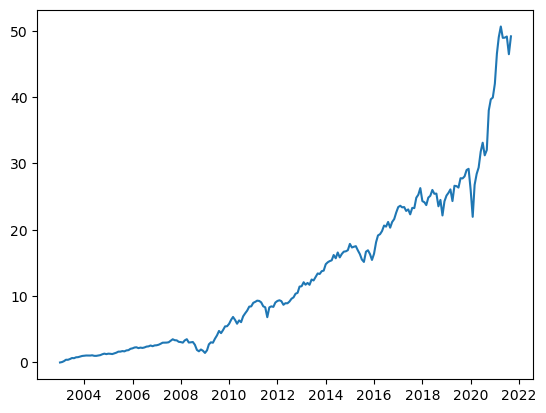

In [46]:
plt.plot(Strategy_monthly_returns['yyyymm'], Strategy_monthly_returns['Cumulative_Return'])